# 1. Import libariers and data 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from scipy.stats import skew
from scipy.special import boxcox1p

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge,LogisticRegression

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_error ,r2_score 
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

import warnings
warnings.filterwarnings('ignore')

palette = sns.color_palette("Spectral")

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

#Save the 'Id' column
train_ID = train.pop('Id')
test_ID = test.pop('Id')

ntrain = train.shape[0]
ntest = test.shape[0]

# concatenate the two dataframes
df = pd.concat((train, test)).reset_index(drop=True)
df.drop(['SalePrice'], axis=1, inplace=True)

In [3]:
df.shape

(2919, 79)

In [4]:
df.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal


# 2. Data review 

In [5]:
# Get the number of columns of each data type
print(f"""
Number of float features: {len(df.select_dtypes('float').columns)}
Number of int features: {len(df.select_dtypes('int').columns)}
Number of object features: {len(df.select_dtypes('object').columns)}
""")  


Number of float features: 11
Number of int features: 25
Number of object features: 43



In [6]:
# check about missing values

print(f"all missing values in data {df.isna().sum().sum()}")

all missing values in data 13965


In [7]:
# columns which have nulls and the percentage of nulls in each column

train_data_na = (df.isnull().sum() / len(df)) 
train_data_na = train_data_na.drop(train_data_na[train_data_na == 0].index).sort_values(ascending=False)
train_missing_data = pd.DataFrame({'mean of nulls' :train_data_na, "number_of_nulls" : df[train_data_na.index].isna().sum()})
train_missing_data

,mean of nulls,number_of_nulls
PoolQC,0.996574,2909
MiscFeature,0.964029,2814
Alley,0.932169,2721
Fence,0.804385,2348
FireplaceQu,0.486468,1420
LotFrontage,0.166495,486
GarageFinish,0.054471,159
GarageQual,0.054471,159
GarageCond,0.054471,159
GarageYrBlt,0.054471,159


There are many missing data, 13965 values. let's handle them.

# 3. Clean data

### Deal with missing values

Missing data can imply a reduction of the sample size. This can prevent us from proceeding with the analysis.
as you see we have alot of null values and it will affect on model's performance.
so let's deal with missing values .

**Put in your mind that** : A general rule is that, if more than half of the data in a column is missing, it's better to drop it then try imputing.

So if percentage of missing values in any column is bigger than 0.5 . it will be dropped.

In [8]:
# drop columns which more than half its data is missing
df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence'] , inplace = True)

* FireplaceQu column


In [9]:
df[df["Fireplaces"]==0][["FireplaceQu"]].isna().sum()

FireplaceQu    1420
dtype: int64

Shit!! All nulls values in FireplaceQu column express zero of the number of fire places. data description says NA means "no fireplace"


In [10]:
df["FireplaceQu"].fillna("Nofireplaces", inplace= True)

* LotFrontage column


Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood so we can fill in missing values by the median LotFrontage of the neighborhood.


In [11]:
# handle columns 
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

* MasVnrType and MasVnrArea columns

In [12]:
df['MasVnrType'].value_counts()

None       1742
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64

In [13]:
df[['MasVnrType', 'MasVnrArea']][df['MasVnrArea']==0].head()

,MasVnrType,MasVnrArea
1,None,0.0
3,None,0.0
5,None,0.0
8,None,0.0
9,None,0.0


In [14]:
df[['MasVnrType', 'MasVnrArea']][df['MasVnrType'].isnull()].head(15)

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN
1691,NaN,NaN
1706,NaN,NaN


About all rows which have nulls in MasVnrType column is also nulls in MasVnrArea column.

<br>

All houses with `None` Masonry veneer type its  Masonry veneer area equal zero.
Now, we will replace nulls in MasVnrType column with `None` and MasVnrArea column with `0.0`.

In [15]:
df["MasVnrType"].fillna("None", inplace=True)
df["MasVnrArea"].fillna(0, inplace=True)

* Impute other columns with mean , median or mode.

In [16]:
for col in df.columns:
        
    if df[col].dtype =="float":
        df[col] = df[col].fillna(df[col].mean())

    elif df[col].dtype =="int":
        df[col] = df[col].fillna(df[col].median())

    elif df[col].dtype =="object":
        df[col] = df[col].fillna(df[col].mode()[0])
            

### low or high cardinality


In [17]:
for col in df.select_dtypes("O").columns:
    
    print("\n" + 5* "-" + col .center(20) + 5 * "-"+"\n")
    print(f"* the number unique values equal {df[col].nunique()} \n")
    print(df[col].value_counts())


-----      MSZoning      -----

* the number unique values equal 5 

RL         2269
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

-----       Street       -----

* the number unique values equal 2 

Pave    2907
Grvl      12
Name: Street, dtype: int64

-----      LotShape      -----

* the number unique values equal 4 

Reg    1859
IR1     968
IR2      76
IR3      16
Name: LotShape, dtype: int64

-----    LandContour     -----

* the number unique values equal 4 

Lvl    2622
HLS     120
Bnk     117
Low      60
Name: LandContour, dtype: int64

-----     Utilities      -----

* the number unique values equal 2 

AllPub    2918
NoSeWa       1
Name: Utilities, dtype: int64

-----     LotConfig      -----

* the number unique values equal 5 

Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64

-----     LandSlope      -----

* the number unique values equal 3 

Gtl    2778
Mod     1

* `Street` column . 2905 records are `Pave` but just 12 records are `Grvl`.
* `Utilities` column . all records are `AllPub` , except for one `NoSeWa` .

This features won't help in predictive modelling. We can then safely remove it.

In [18]:
# drop categorical columns with low or high cardinality
df.drop(columns=['Street','Utilities','MSSubClass'], inplace=True)

### Feature engineering

Let's engine some feature 

* Create `'TotalSF'` feature , Total Square Feet feature , by adding the values of `'TotalBsmtSF'` ,`'1stFlrSF'` and `'2ndFlrSF'` columns .


In [19]:
#Adding Total Square Feet feature 
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

year columns

In [20]:
year_cols=[f for f in df.columns if "Year" in f or "Yr" in f]
df[year_cols].head()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
0,2003,2003,2003.0,2008
1,1976,1976,1976.0,2007
2,2001,2002,2001.0,2008
3,1915,1970,1998.0,2006
4,2000,2000,2000.0,2008


* create `'HouseAge'` feature , house age when it was sold ,  by subtract the values of `'YrSold'` and `'YearBuilt'`columns.
* create `'AgeRemod'` feature , age of renovated house when it was sold ,  by subtract the values of `'YrSold'` and`'YearRemodAdd'` columns.
* create `'AgeGrgSold'` feature , age of garage when it was sold , by subtract the values of `'YrSold'` and `'GarageYrBlt'` columns.


In [21]:
#House age when it was sold
df['HouseAge'] = df['YrSold']-df['YearBuilt']
#age of renovated house when it was sold
df['AgeRemod'] = df['YrSold']-df['YearRemodAdd']
#age of garage when it was sold
df['AgeGrgSold'] = df['YrSold']-df['GarageYrBlt']

basement columns

In [22]:
df[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']].head()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
0,706.0,0.0,150.0,856.0
1,978.0,0.0,284.0,1262.0
2,486.0,0.0,434.0,920.0
3,216.0,0.0,540.0,756.0
4,655.0,0.0,490.0,1145.0


create `TotalBsmtSF` feature , Total Basement Area , by adding the values of `BsmtFinSF1` , `BsmtFinSF2` and `BsmtUnfSF` columns.
So we will drop these columns.

drop columns:

`BsmtFinSF1` , `BsmtFinSF2` , `BsmtUnfSF` , `YrSold` , `YearBuilt` , `GarageYrBlt` , `YearRemodAdd` , `TotalBsmtSF` , `1stFlrSF` and `2ndFlrSF`

In [23]:
# drop leaky columns
df.drop(columns=['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF' ,'YrSold',
                     'YearBuilt','GarageYrBlt','YearRemodAdd' ,
                     'TotalBsmtSF' ,'1stFlrSF','2ndFlrSF'], inplace=True)

In [24]:
df.shape

(2919, 66)

# 4. Explore data

### 4.1. Explore numerical features

In [25]:
#  explore porch columns

porch_cols=[f for f in df.columns if "Porch" in f]
df[porch_cols].describe([0.8,0.84,0.9])

,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch
count,2919.000000,2919.000000,2919.000000,2919.000000
mean,47.486811,23.098321,2.602261,16.062350
std,67.575493,64.244246,25.188169,56.184365
min,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000
80%,85.000000,0.000000,0.000000,0.000000
84%,101.000000,0.000000,0.000000,0.000000
90%,131.200000,112.000000,0.000000,0.000000
max,742.000000,1012.000000,508.000000,576.000000


As you see above `84%` of 3SsnPorch , EnclosedPorch and ScreenPorch is equal zero . This will cause skewness data that reduce performane our model.
so we will drop them.

In [26]:
df[["LowQualFinSF","MiscVal"]].describe([0.85,0.9,0.95])

,LowQualFinSF,MiscVal
count,2919.000000,2919.000000
mean,4.694416,50.825968
std,46.396825,567.402211
min,0.000000,0.000000
50%,0.000000,0.000000
85%,0.000000,0.000000
90%,0.000000,0.000000
95%,0.000000,0.000000
max,1064.000000,17000.000000


Shit!! Also LowQualFinSF and MiscVal columns . Above `95%` of its values equal zero . we will drop it.

In [27]:
# drop columns
df.drop(columns=['3SsnPorch', 'EnclosedPorch' ,'ScreenPorch'] , inplace=True)
df.drop(columns=['LowQualFinSF',"MiscVal"] , inplace=True)

In [28]:
descrete_cols = [col for col in df.columns if df[col].nunique() < 15 and df[col].dtypes != 'O']

# numerical columns
num_cols = [col for col in df.columns if df[col].dtypes != 'O']
num_cols = [col for col in num_cols if col not in descrete_cols]

print(f'number of numerical columns: {len(num_cols)}')
print(f'num_cols: {num_cols}')
print('------------------------')
print(f'number of descrete columns: {len(descrete_cols)}')
print(f'descrete columns: {descrete_cols}')

number of numerical columns: 11
num_cols: ['LotFrontage', 'LotArea', 'MasVnrArea', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'TotalSF', 'HouseAge', 'AgeRemod', 'AgeGrgSold']
------------------------
number of descrete columns: 13
descrete columns: ['OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'PoolArea', 'MoSold']


In [29]:
def two_plots_num_column(feature):
    
    print(f"the skewness value of {feature} column = {df[feature].skew():.2f}")
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.title('histgram')
    sns.histplot(data=df, x=feature, kde=True)
    plt.axvline(x = df[feature].mean(), c = 'red')
    plt.axvline(x = df[feature].median(), c = 'green')

    plt.subplot(1,2,2)
    plt.title('Boxplot')
    sns.boxplot(y=df[feature])

the skewness value of LotFrontage column = 1.51
the skewness value of LotArea column = 12.83
the skewness value of MasVnrArea column = 2.61
the skewness value of GrLivArea column = 1.27
the skewness value of GarageArea column = 0.24
the skewness value of WoodDeckSF column = 1.84
the skewness value of OpenPorchSF column = 2.54
the skewness value of TotalSF column = 1.52
the skewness value of HouseAge column = 0.60
the skewness value of AgeRemod column = 0.45
the skewness value of AgeGrgSold column = 0.39


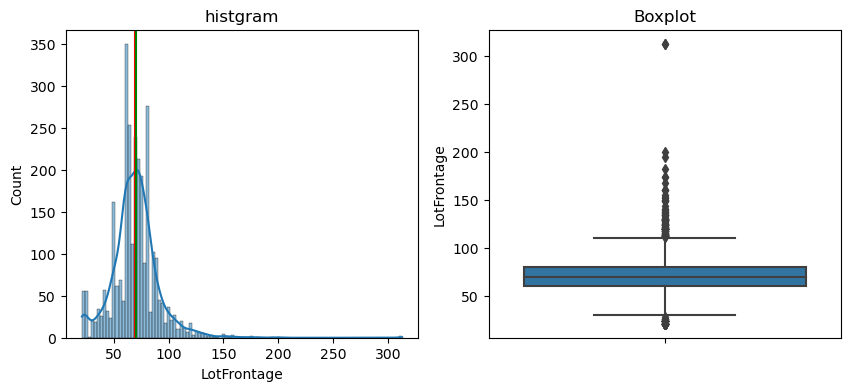

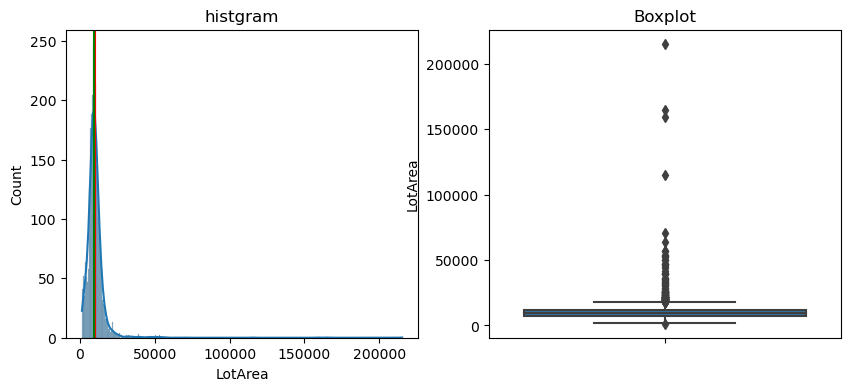

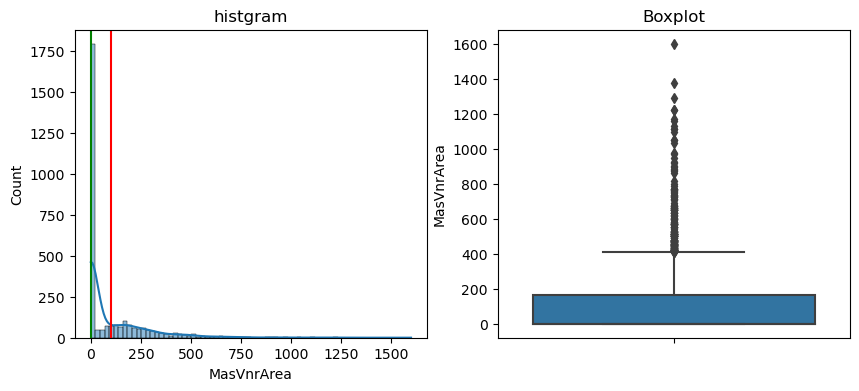

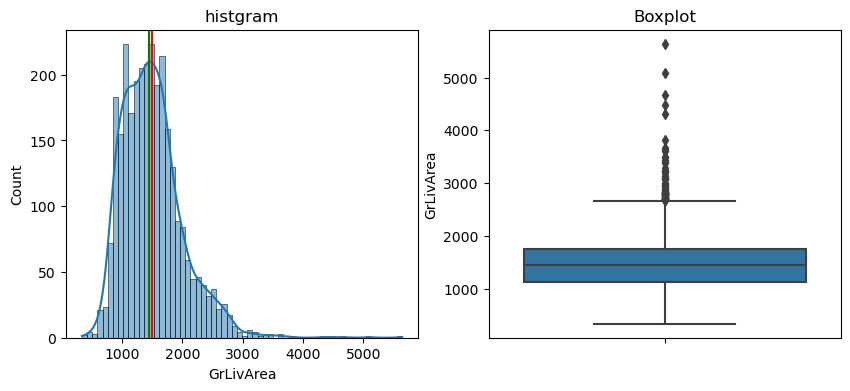

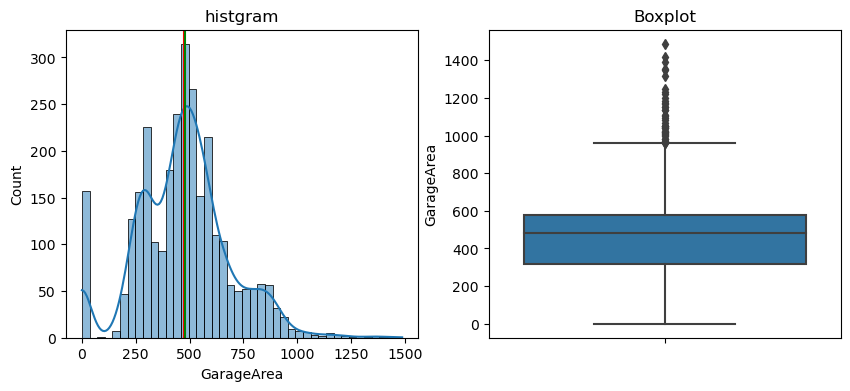

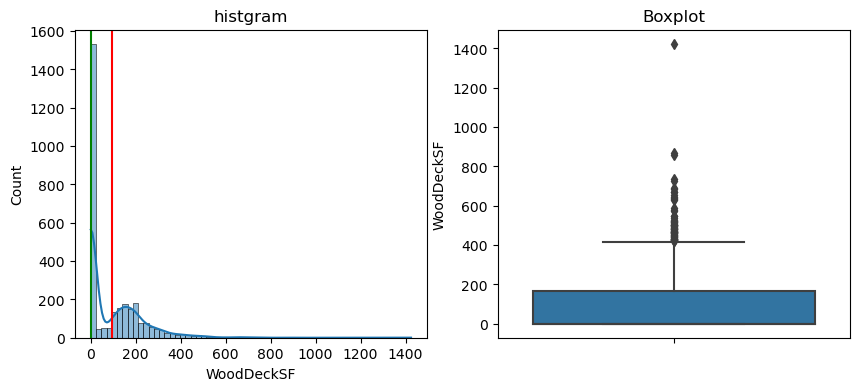

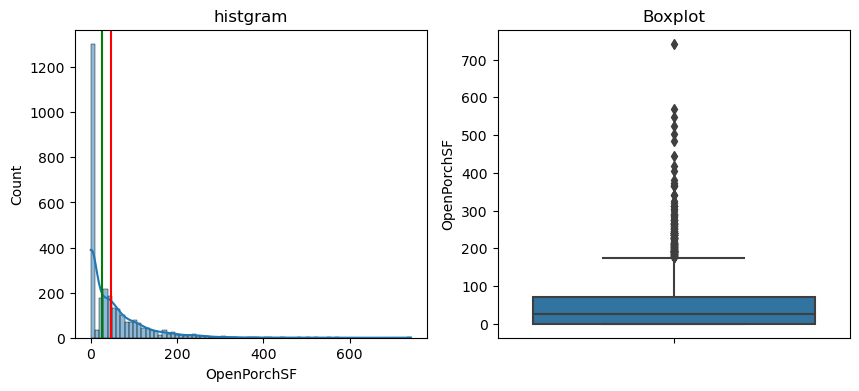

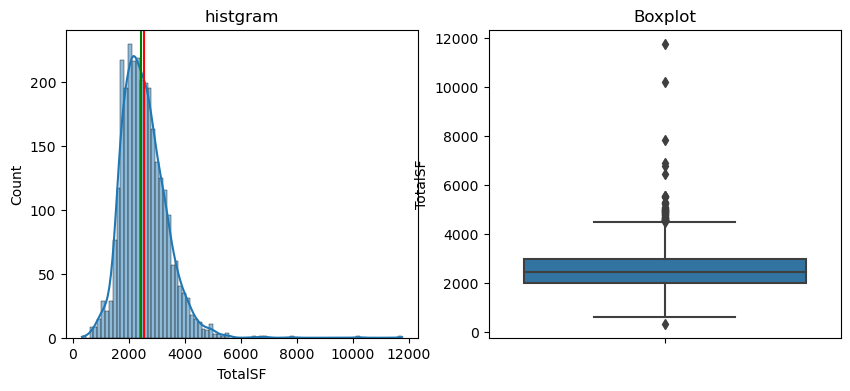

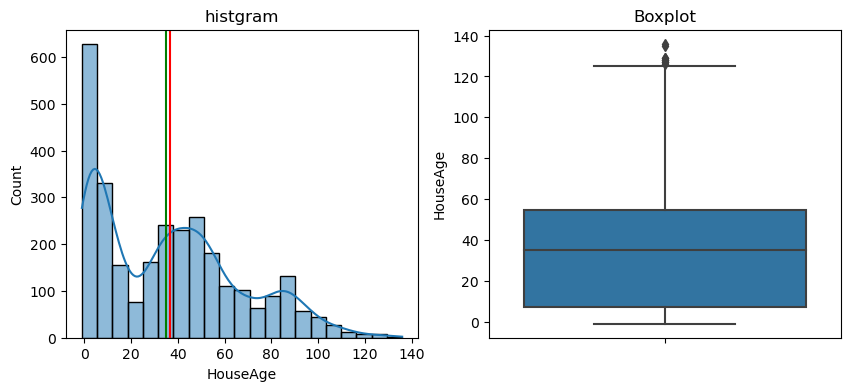

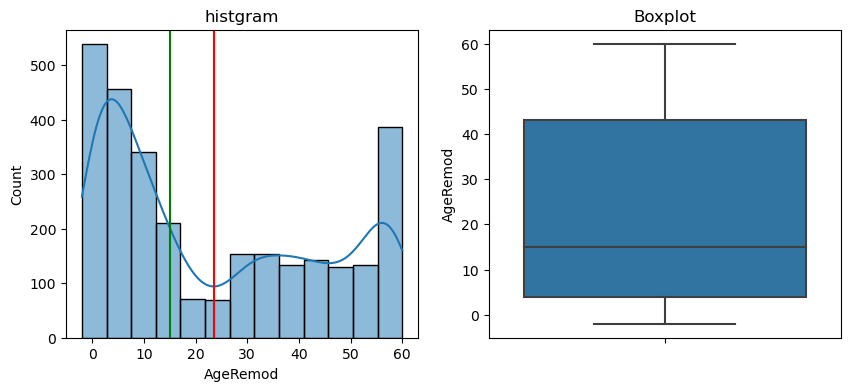

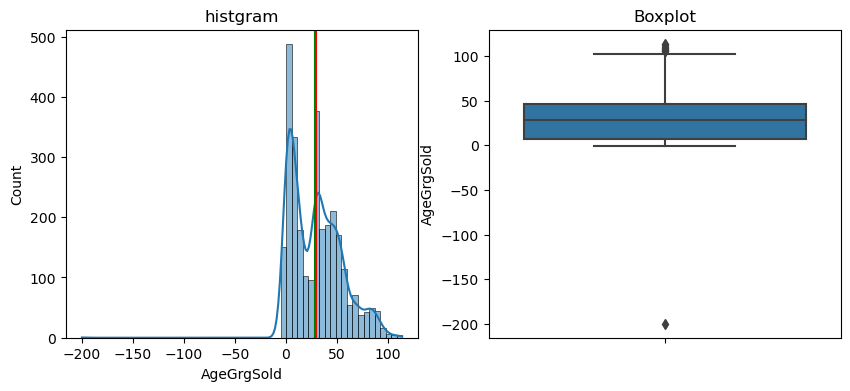

In [30]:
for col in num_cols:
    two_plots_num_column(col)

### Deal with outliers and skewness

### 1- Outliers

GrLivArea column

In [31]:
# Create a boolean mask to identify the values that are greater than 3000
mask = df['GrLivArea'] > 3000

# Replace the values that satisfy the mask with the mean value
df.loc[mask, 'GrLivArea'] = df['GrLivArea'].mean()

the skewness value of GrLivArea column = 0.65


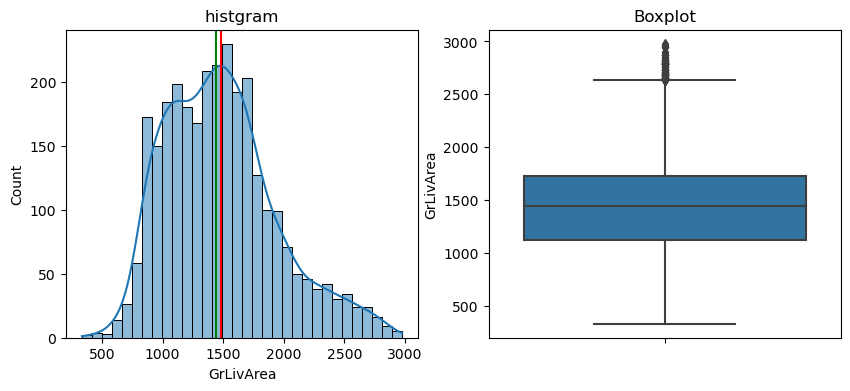

In [32]:
two_plots_num_column('GrLivArea')

TotalSF column

In [33]:
# Create a boolean mask to identify the values that are greater than 3000
mask = df['TotalSF'] > 5500

# Replace the values that satisfy the mask with the mean value
df.loc[mask, 'TotalSF'] = df['TotalSF'].mean()

the skewness value of TotalSF column = 0.58


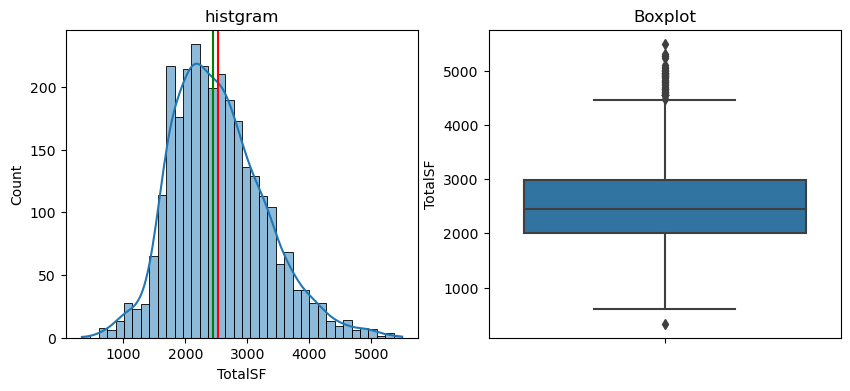

In [34]:
two_plots_num_column('TotalSF')

LotFrontage column

In [35]:
# train data
# Create a boolean mask to identify the values that are greater than 150
mask = df['LotFrontage'] > 150

# Replace the values that satisfy the mask with the mean value
df.loc[mask, 'LotFrontage'] = df['LotFrontage'].mean()

the skewness value of LotFrontage column = 0.23


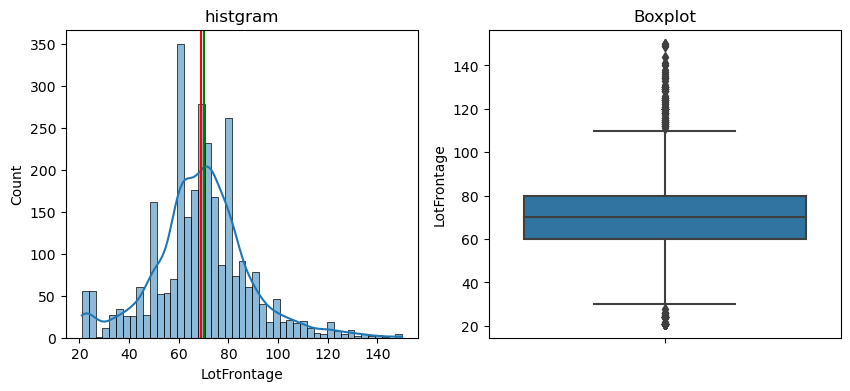

In [36]:
two_plots_num_column('LotFrontage')

LotArea column

In [37]:
# Create a boolean mask to identify the values that are greater than 20000
mask = df['LotArea'] > 20000

# Replace the values that satisfy the mask with the mean value
df.loc[mask, 'LotArea'] = df['LotArea'].mean()

the skewness value of LotArea column = 0.09


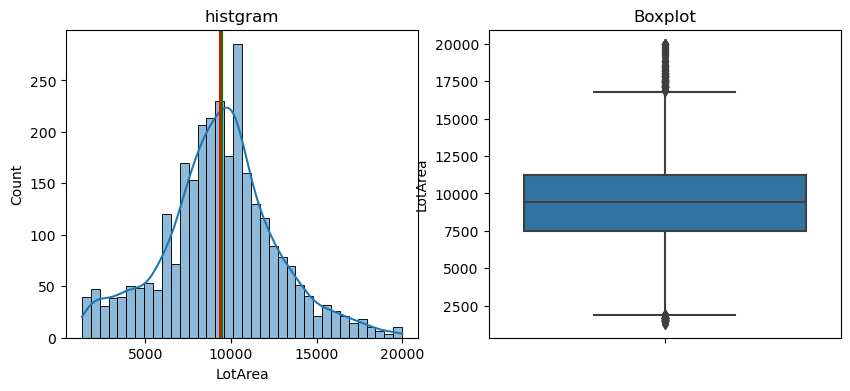

In [38]:
two_plots_num_column('LotArea')

GarageArea column

In [39]:
# Create a boolean mask to identify the values that are greater than 1100
mask = df['GarageArea'] > 1100

# Replace the values that satisfy the mask with the mean value
df.loc[mask, 'GarageArea'] = df['GarageArea'].mean()

the skewness value of GarageArea column = -0.01


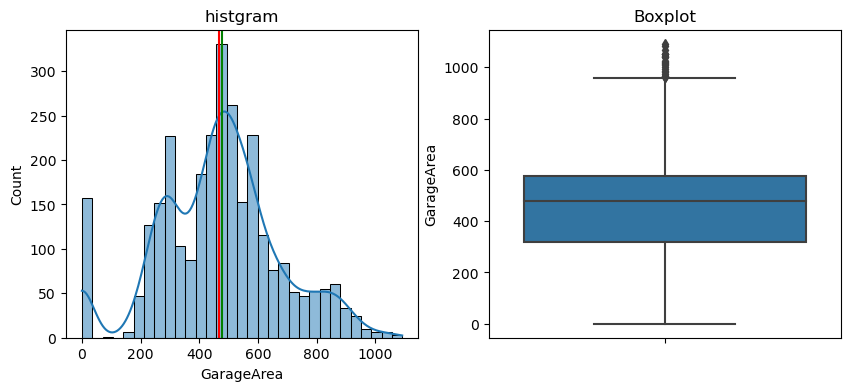

In [40]:
two_plots_num_column('GarageArea')

WoodDeckSF column

In [41]:
# Create a boolean mask to identify the values that are greater than 400
mask = df['WoodDeckSF'] > 400

# Replace the values that satisfy the mask with the mean value
df.loc[mask, 'WoodDeckSF'] = df['WoodDeckSF'].mean()

the skewness value of WoodDeckSF column = 0.96


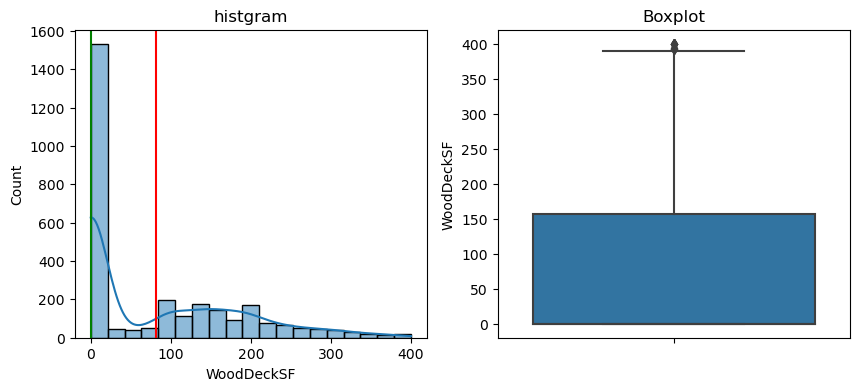

In [42]:
two_plots_num_column('WoodDeckSF')

MasVnrArea column

In [43]:
# Create a boolean mask to identify the values that are greater than 500
mask = df['MasVnrArea'] > 500

# Replace the values that satisfy the mask with the mean value
df.loc[mask, 'MasVnrArea'] = df['MasVnrArea'].mean()

the skewness value of MasVnrArea column = 1.56


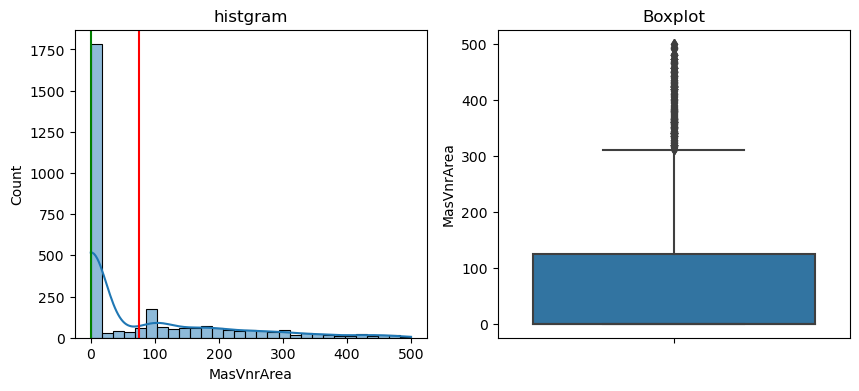

In [44]:
two_plots_num_column('MasVnrArea')

AgeGrgSold column

In [45]:
# Create a boolean mask to identify the values that are lower than 0
mask = df['AgeGrgSold'] < 0

# Replace the values that satisfy the mask with the mean value
df.loc[mask, 'AgeGrgSold'] = df['AgeGrgSold'].mean()

the skewness value of AgeGrgSold column = 0.68


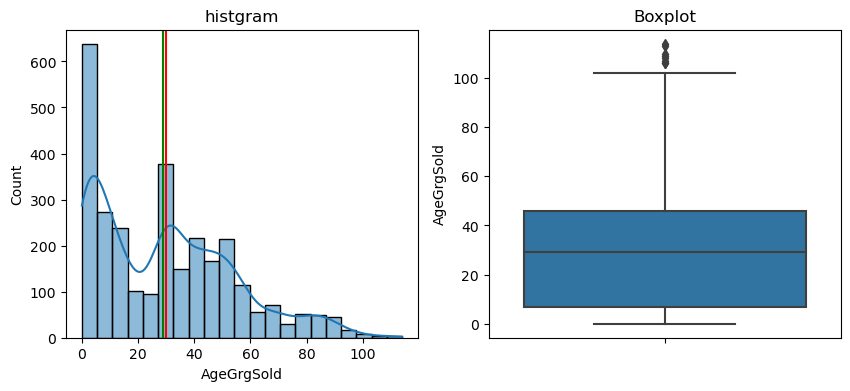

In [46]:
two_plots_num_column('AgeGrgSold')

### 2-skewness

In [47]:
# Calculate the skewness values
skewness_vals = skew(df[num_cols], axis=0)

# Create a DataFrame of skewness values
skewness_df = pd.DataFrame({'Feature': num_cols, 'Skewness': skewness_vals})
skewness_df = skewness_df.sort_values('Skewness', ascending=False)

skewness_df

,Feature,Skewness
6,OpenPorchSF,2.535114
2,MasVnrArea,1.563686
5,WoodDeckSF,0.955454
10,AgeGrgSold,0.675976
3,GrLivArea,0.647381
8,HouseAge,0.598609
7,TotalSF,0.578577
9,AgeRemod,0.450226
0,LotFrontage,0.231913
1,LotArea,0.087963


In [48]:
skewness_df = skewness_df[skewness_df['Skewness'] >= 0.59]

skewed_features = skewness_df['Feature'].values
for feat in skewed_features:
    
    # Apply a logarithmic transformation to non-zero values
    # Add 1 to avoid issues with log(0)
    df[feat] = np.log(df[feat] + 1)


the skewness value of OpenPorchSF column = -0.04


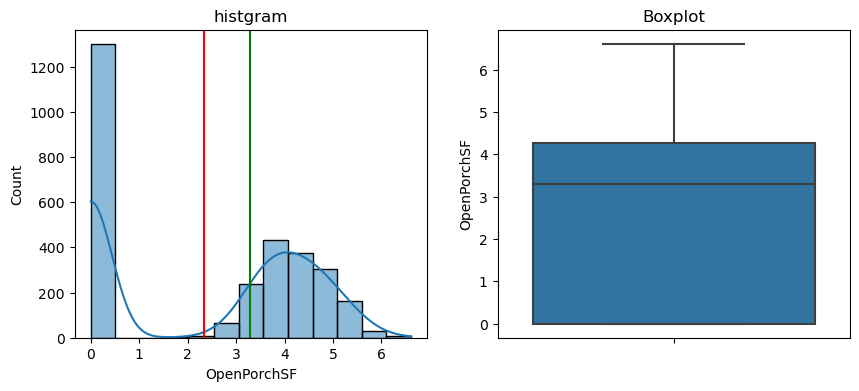

In [49]:
#check
two_plots_num_column('OpenPorchSF')

### 4.2. explore descrete columns

In [50]:
print(f'number of descrete columns: {len(descrete_cols)}')
print(f'descrete columns: {descrete_cols}')

number of descrete columns: 13
descrete columns: ['OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'PoolArea', 'MoSold']


In [51]:
def two_plots_descrete_column(feature):
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    plt.title(f'{feature} Histogram')
    ax = sns.countplot(data=train , x=feature ,palette="Set2")
    plt.xticks(rotation=90)
    ax.bar_label(ax.containers[0], label_type='edge')
    
    plt.subplot(1,2,2)
    plt.title(f'{feature} vs Price')
    sns.boxplot(x=train[feature], y=train["SalePrice"],palette="Set2")
    plt.xticks(rotation=90)
    
    plt.tight_layout()

OverallQual column

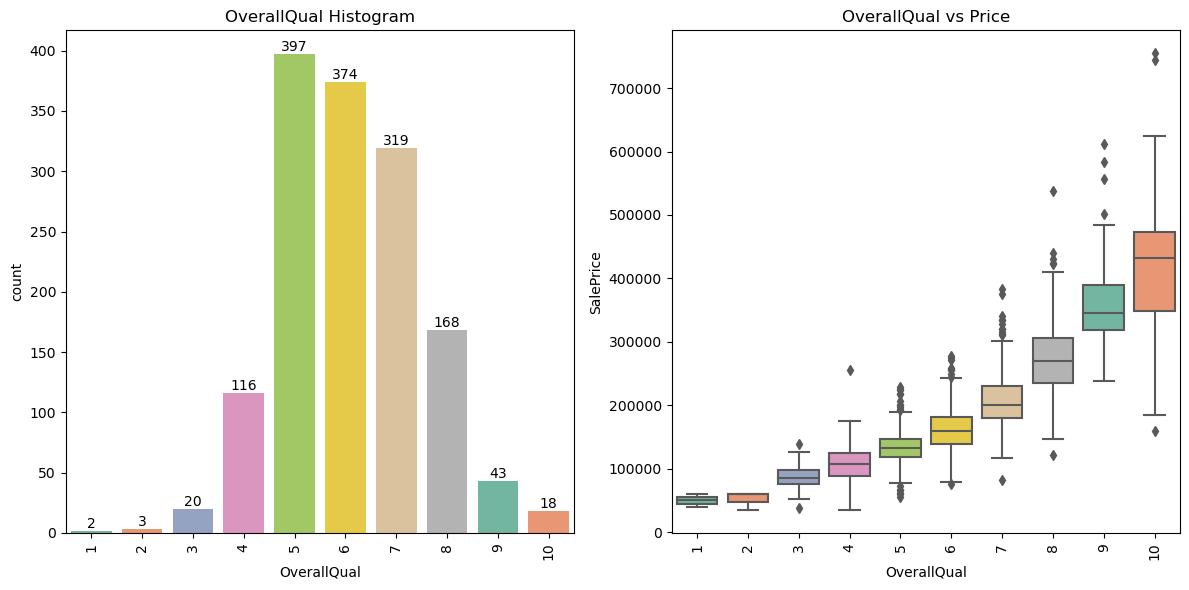

In [52]:
two_plots_descrete_column('OverallQual')

* People pay more for better quality? Nothing new here. Let's move on.

GarageCars

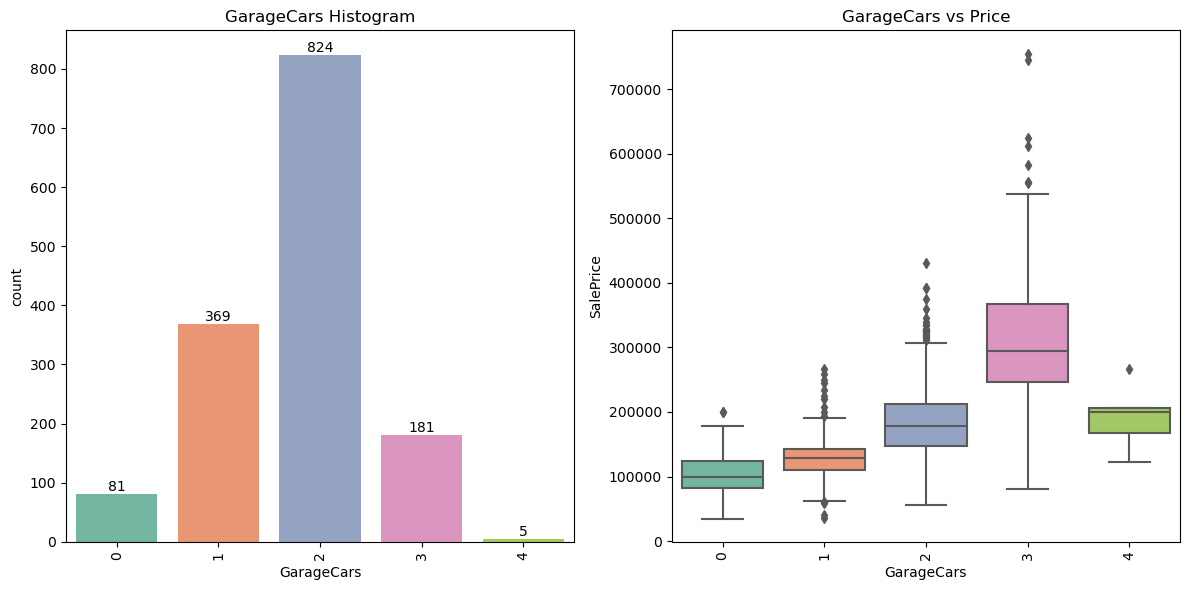

In [53]:
two_plots_descrete_column('GarageCars')

* 4-car garages result in less Sale Price? That doesn't make much sense. it must have outliers.
* There are only 5 houses have 4-car garages.

In [54]:
df['GarageCars'].value_counts()

2.000000    1594
1.000000     776
3.000000     374
0.000000     157
4.000000      16
5.000000       1
1.766621       1
Name: GarageCars, dtype: int64

In [56]:
df['GarageCars'].replace({4: 2, 5: 2}, inplace=True)

PoolArea column

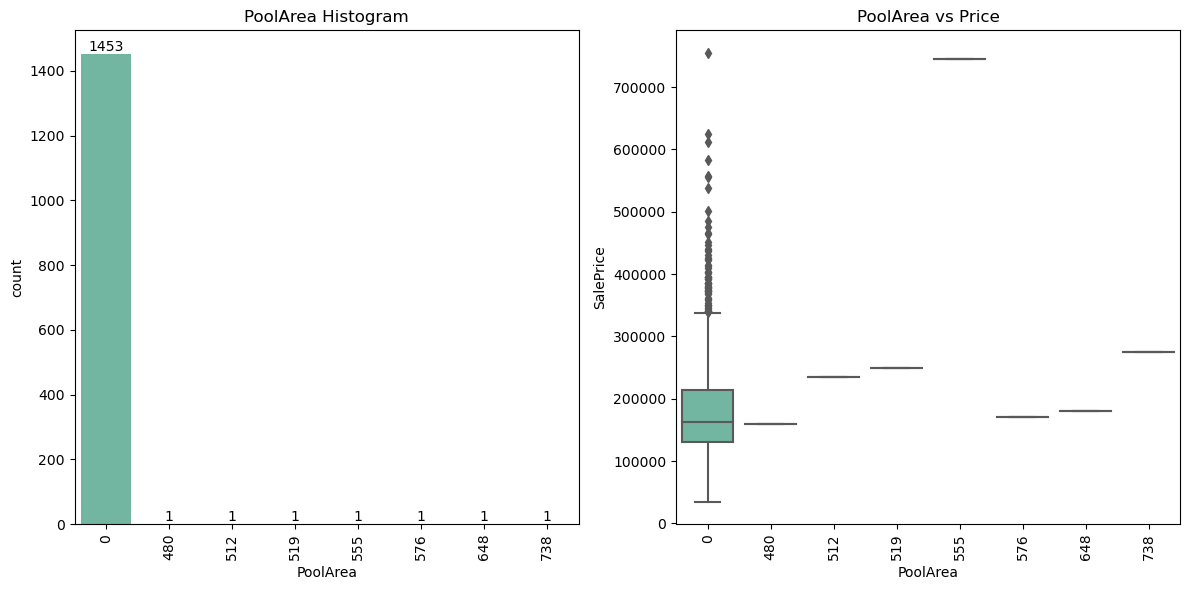

In [59]:
two_plots_descrete_column('PoolArea')

In [60]:
df['PoolArea'].describe([0.8,0.9,0.95])

count    2919.000000
mean        2.251799
std        35.663946
min         0.000000
50%         0.000000
80%         0.000000
90%         0.000000
95%         0.000000
max       800.000000
Name: PoolArea, dtype: float64

* above 95% of its values equal zero . we will drop it

In [61]:
df.drop(columns='PoolArea' , inplace=True)

TotRmsAbvGrd column

* most houses have 6 rooms above grade (does not include bathrooms), It looks like an outlier

In [67]:
df[df['TotRmsAbvGrd']==14]

,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,PavedDrive,WoodDeckSF,OpenPorchSF,MoSold,SaleType,SaleCondition,TotalSF,HouseAge,AgeRemod,AgeGrgSold


In [66]:
df['TotRmsAbvGrd'].replace({14: 10}, inplace=True)

MoSold column

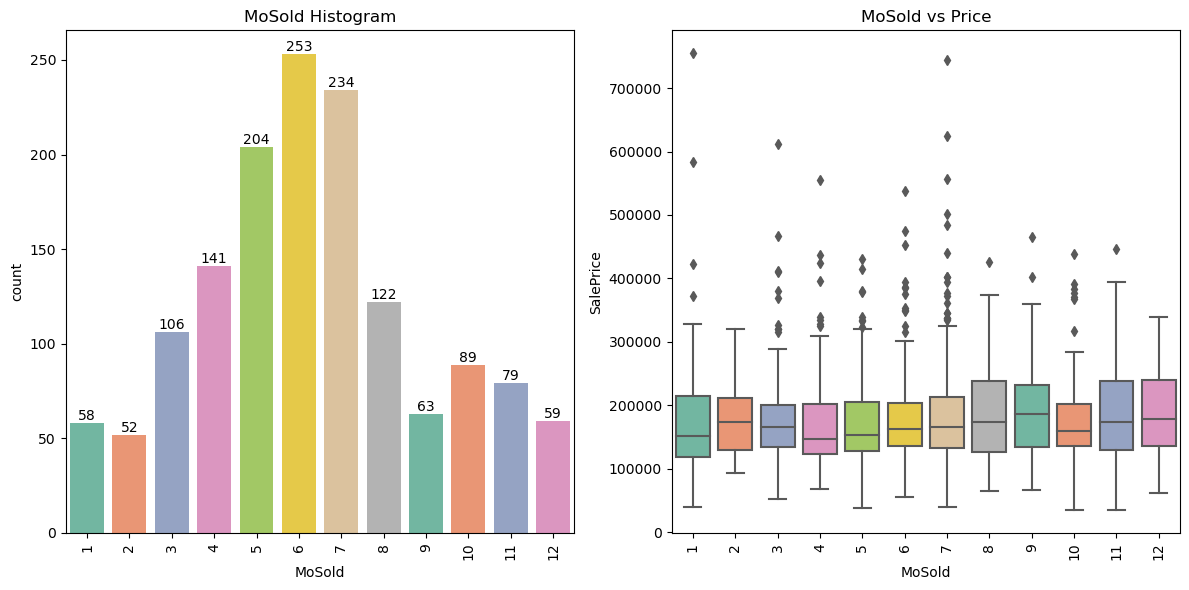

In [68]:
two_plots_descrete_column('MoSold')

* June month have the most sold house . The price of houses is almost constant during the year.

### 4.3. explore categorical data

In [69]:
cat_cols = [col for col in df.columns if df[col].dtypes == 'O']
cat_but_car = [col for col in df.columns if df[col].nunique() > 20 and df[col].dtypes == 'O']

# categorical columns
cat_cols = [col for col in cat_cols if col not in cat_but_car]

In [70]:
df[cat_cols].head()

,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Reg,Lvl,Inside,Gtl,Norm,Norm,1Fam,2Story,Gable,...,Gd,Typ,Nofireplaces,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Reg,Lvl,FR2,Gtl,Feedr,Norm,1Fam,1Story,Gable,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,IR1,Lvl,Inside,Gtl,Norm,Norm,1Fam,2Story,Gable,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,IR1,Lvl,Corner,Gtl,Norm,Norm,1Fam,2Story,Gable,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,IR1,Lvl,FR2,Gtl,Norm,Norm,1Fam,2Story,Gable,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


In [71]:
# label encoder
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in ['int64', 'float64'] and df[col].nunique() <= 2]

for col in binary_cols:
    df = label_encoder(df, col)


In [72]:
# one hot encoder
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
ohe_cols = [col for col in df.columns if 25 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)

In [73]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and
                (df[col].value_counts() / len(df) < 0.01).any(axis=None)]

df.drop(useless_cols, axis=1, inplace=True)

print(useless_cols)

['MSZoning_RH', 'LotShape_IR3', 'LotConfig_FR3', 'LandSlope_Sev', 'Neighborhood_Blueste', 'Neighborhood_NPkVill', 'Neighborhood_Veenker', 'Condition1_PosA', 'Condition1_RRAe', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Feedr', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_1.5Unf', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'OverallQual_2', 'OverallCond_2', 'RoofStyle_Gambrel', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_CBlock', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_CBlock', 'Exterior2nd_ImStucc', 'Exterior2nd_Other', 'Exterior2nd_Stone', 'ExterCond_Po', 'Foundation_Stone', 'Foundation_Wood', 'BsmtCond_Po', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW', 'Heating_Wall', 'HeatingQC_Po', 'Ele

In [74]:
df.shape

(2919, 197)

# 5. bivariate analysis

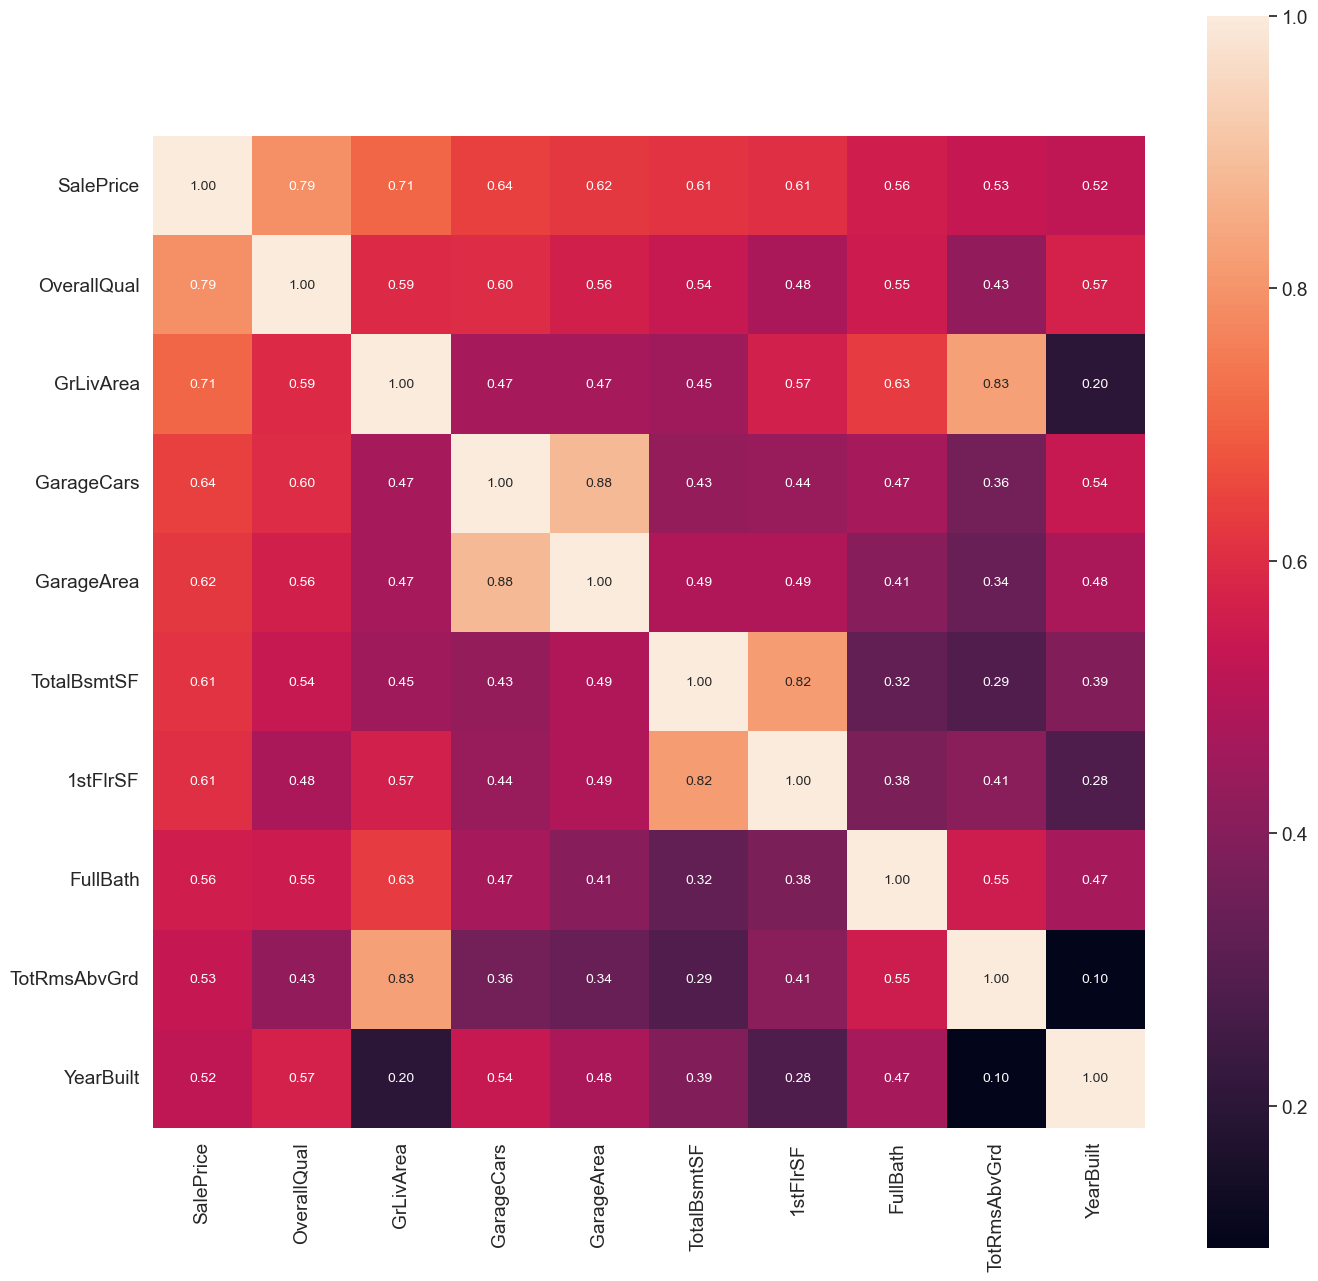

In [75]:
plt.figure(figsize=(16,16))
corrmat = train.corr()
columns = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
correlation_matrix = np.corrcoef(train[columns].values.T)
sns.set(font_scale=1.25)
heat_map = sns.heatmap(correlation_matrix, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=columns.values, xticklabels=columns.values)
plt.show()


# 6. modeling

In [76]:
train_processed = df[:ntrain]
test_processed = df[ntrain:]
print("Train_processed",train_processed.shape)
print("Test_processed",test_processed.shape)

Train_processed (1460, 197)
Test_processed (1459, 197)


In [118]:
test_processed.isna().sum()

LotFrontage              0
LotArea                  0
MasVnrArea               0
CentralAir               0
GrLivArea                0
                        ..
SaleType_New             0
SaleType_WD              0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 197, dtype: int64

In [77]:
X = train_processed
y = train["SalePrice"]

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=45)
print("X_train",X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)

X_train (1095, 197)
y_train (1095,)
X_test (365, 197)
y_test (365,)


### Hyperparameter Optimization with RandomSearchCV¶

In [91]:
def cross_val(model):
    cv_results = cross_val_score(model, X, y, cv=5)
    
    #average accuracy.
    mean_score = round(np.mean(cv_results)*100, 3)
    
    #standard deviation of the data to see degree of variance in the results.
    std_dev = round(np.std(cv_results), 3)
    
    return {'mean': mean_score, 'std': std_dev }


def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

#### 1-Random Forest Regressor


In [80]:
#Random Forest Regressor
rf = RandomForestRegressor(random_state=17)

rf_random_params = {"max_depth": np.random.randint(5, 50, 10),
                    "max_features": [3, 5, 7, "auto", "sqrt"],
                    "min_samples_split": np.random.randint(2, 50, 20),
                    "n_estimators": [int(x) for x in np.linspace(start=200, stop=1500, num=10)]}

rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=rf_random_params,
                               n_iter=100,  
                               cv=3,
                               verbose=True,
                               random_state=42,
                               n_jobs=-1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=17),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': array([28, 27, 15, 25, 35, 46, 29, 28, 46, 24]),
                                        'max_features': [3, 5, 7, 'auto',
                                                         'sqrt'],
                                        'min_samples_split': array([38, 33, 29,  4, 45, 36, 41, 37, 39,  2,  4, 17,  9,  6, 35, 40, 16,
        3, 18, 23]),
                                        'n_estimators': [200, 344, 488, 633,
                                                         777, 922, 1066, 1211,
                                                         1355, 1500]},
                   random_state=42, verbose=True)

In [81]:
print(rf_random.best_params_)

rf_random_final = rf.set_params(**rf_random.best_params_, random_state=17).fit(X, y)

{'n_estimators': 488, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 24}


In [113]:
preds_rf = rf_random_final.predict(X_test)
mae_rf = round(mean_absolute_error(y_test, preds_rf), 2)
cv_rf = cross_val(rf_random_final)

print(mae_rf)
print(cv_rf)

6424.27
{'mean': 85.409, 'std': 0.039}


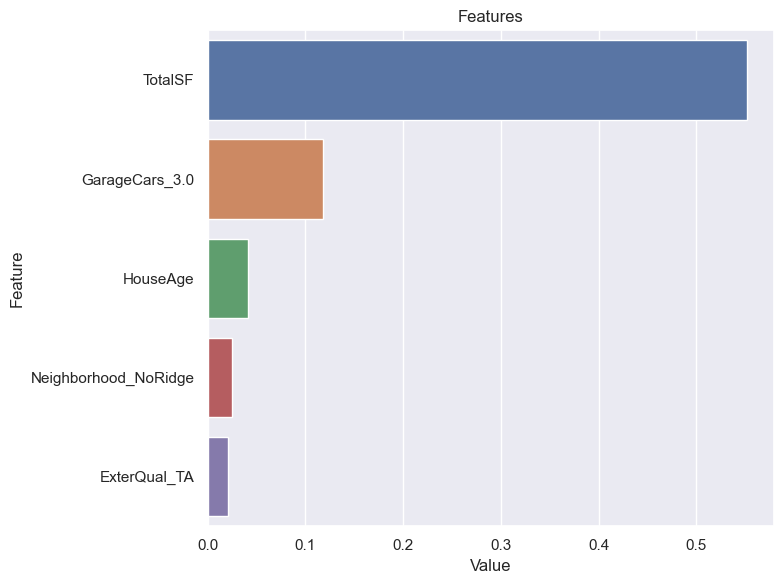

In [87]:
plot_importance(rf_random_final, X_train, num=5)

#### 2-XGBoost Regressor

In [88]:
xgb = XGBRegressor(random_state=17)

xgb_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 500, 1000],
                  "subsample": [0.7, 1]}

xgb_random = RandomizedSearchCV(estimator=xgb,
                               param_distributions=xgb_params, 
                               verbose=True,n_iter=100,
                               n_jobs =-1)

xgb_random.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          max_delta_step=None, max_depth=None,
                                          max_le

In [89]:
print(xgb_random.best_params_)

xgb_random_final = xgb.set_params(**xgb_random.best_params_, random_state=17).fit(X, y)

{'subsample': 0.7, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1}


In [112]:
preds_xgb = xgb_random_final.predict(X_test)
mae_xgb = round(mean_absolute_error(y_test, preds_xgb), 2)
cv_xgb = cross_val(xgb_random_final)

print(mae_xgb)
print(cv_xgb)

964.91
{'mean': 87.931, 'std': 0.022}


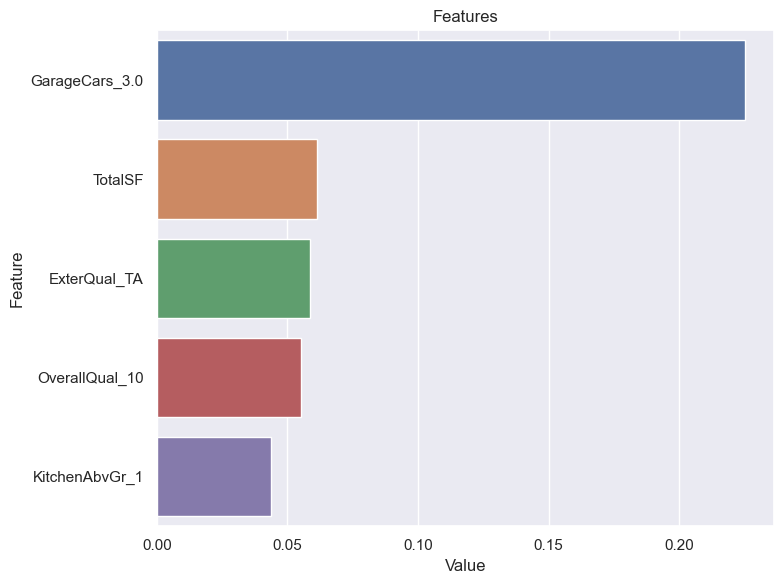

In [94]:
plot_importance(xgb_random_final, X_train, num=5)

#### 3-CatBoost Regressor

In [95]:
# CatBoost Regressor
cb = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
cb_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}
cb_random = GridSearchCV(estimator=cb,param_grid=cb_params, n_jobs=-1)

cb_random.fit(X_train, y_train)

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x0000022562A19BE0>,
             n_jobs=-1,
             param_grid={'depth': [3, 6], 'iterations': [200, 500],
                         'learning_rate': [0.01, 0.1]})

In [96]:
print(cb_random.best_params_)

cb_random_final = cb.set_params(**cb_random.best_params_, random_state=17).fit(X, y)

{'depth': 3, 'iterations': 500, 'learning_rate': 0.1}


In [110]:
preds_cb= cb_random_final.predict(X_test)
mae_cb = round(mean_absolute_error(y_test, preds_cb),2)
cv_cb = cross_val(cb_random_final)

print(mae_cb)
print(cv_cb)

10127.56
{'mean': 89.63, 'std': 0.014}


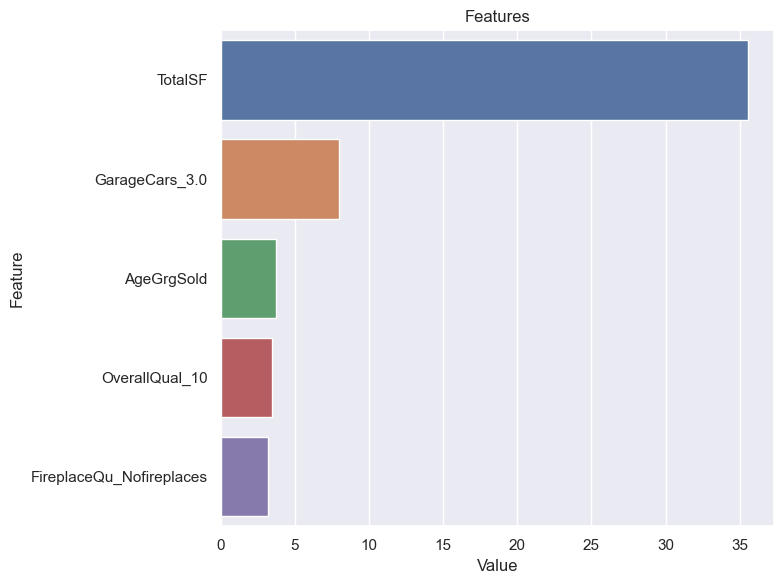

In [98]:
plot_importance(cb_random_final, X_train, num=5)

# 7. Evaluate

In [115]:
model_performances = pd.DataFrame({
    
    "CV_mean": [cv_rf['mean'], cv_xgb['mean'], cv_cb['mean']],
    "CV_std": [cv_rf['std'], cv_xgb['std'], cv_cb['std']],
    "MAE": [mae_rf, mae_xgb, mae_cb],
    
}, index=['RandomForest', 'XGBoost', 'CatBoost'])

model_performances

,CV_mean,CV_std,MAE
RandomForest,85.409,0.039,6424.27
XGBoost,87.931,0.022,964.91
CatBoost,89.630,0.014,10127.56


In [116]:
predict1 = rf_random_final.predict(test_processed)
predict2 = xgb_random_final.predict(test_processed)
predict3 = cb_random_final.predict(test_processed)
predict_y = ( predict1*0.30 + predict2 * 0.30 + predict3 * 0.40)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

# 8. Submission

In [ ]:
predictions = pd.DataFrame({'Id': test_ID,
                           'SalePrice': predict_y})
predictions.to_csv("submission2.csv", index=False)